In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
batch_size = 128
epochs = 50
lr = 0.0001
latent_dim = 100

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5)) # Normalize to [-1, 1]
                                ])

mnist = MNIST(root="./data", train=True, download=True, transform=transform)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

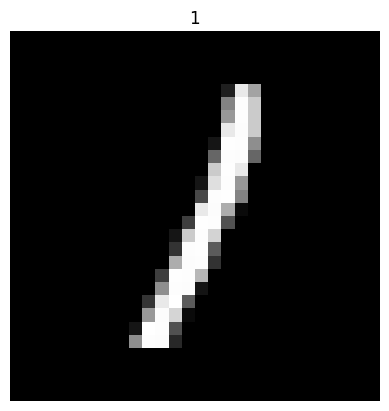

In [8]:
# Visualizing the data
for images, labels in data_loader:
  # Select the first image from the batch
  image = images[0]
  # Remove the channel dimension and reshape to (28, 28)
  plt.imshow(image.squeeze(0).numpy(), cmap="gray")
  plt.axis("off")
  # Get the label for the first image
  label = labels[0].item()
  plt.title(label)
  plt.show()
  # Optionally, break the loop after displaying one image
  break

In [9]:
# Generator
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )

  def forward(self, z):
    return self.model(z).view(-1, 1, 28, 28)

In [10]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(28 * 28, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    return self.model(img.view(img.size(0), -1))

In [14]:
# Initialize models
generator = Generator(latent_dim)
discriminator = Discriminator()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
criterion.to(device)

BCELoss()

In [16]:
os.makedirs("gan_images", exist_ok=True)
for epoch in range(epochs):
  for i, (images, _) in enumerate(data_loader):
    # Ground truths
    real = torch.ones(images.size(0), 1).to(device)
    fake = torch.zeros(images.size(0), 1).to(device)

    # Real Img
    real_img = images.to(device)

    # Train Discriminator
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_img), real)
    z = torch.randn(images.size(0), latent_dim).to(device)
    fake_imgs = generator(z)
    fake_loss = criterion(discriminator(fake_imgs.detach()), fake)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()
    g_loss = criterion(discriminator(fake_imgs), real)
    g_loss.backward()
    optimizer_g.step()

     # Print training progress
    if i % 200 == 0:
        print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(data_loader)}] "
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

   # Save sample generated images at the end of each epoch
  if epoch % 10 == 0:
      with torch.no_grad():
          sample_z = torch.randn(16, latent_dim).to(device)
          sample_imgs = generator(sample_z)
          sample_imgs = (sample_imgs + 1) / 2.0  # Rescale to [0, 1]
          save_image(sample_imgs, f"gan_images/epoch_{epoch+1}.png", nrow=4)

print("Training complete!")

[Epoch 1/50] [Batch 0/469] [D loss: 1.3810] [G loss: 0.6911]
[Epoch 1/50] [Batch 200/469] [D loss: 0.2012] [G loss: 2.0890]
[Epoch 1/50] [Batch 400/469] [D loss: 0.0718] [G loss: 10.6412]
[Epoch 2/50] [Batch 0/469] [D loss: 0.1265] [G loss: 10.6262]
[Epoch 2/50] [Batch 200/469] [D loss: 1.0335] [G loss: 3.8591]
[Epoch 2/50] [Batch 400/469] [D loss: 0.1585] [G loss: 4.0665]
[Epoch 3/50] [Batch 0/469] [D loss: 0.8685] [G loss: 1.2326]
[Epoch 3/50] [Batch 200/469] [D loss: 0.4719] [G loss: 1.9017]
[Epoch 3/50] [Batch 400/469] [D loss: 0.6121] [G loss: 2.5221]
[Epoch 4/50] [Batch 0/469] [D loss: 0.1375] [G loss: 5.0016]
[Epoch 4/50] [Batch 200/469] [D loss: 0.0973] [G loss: 4.2171]
[Epoch 4/50] [Batch 400/469] [D loss: 0.1381] [G loss: 4.5785]
[Epoch 5/50] [Batch 0/469] [D loss: 0.0487] [G loss: 4.5809]
[Epoch 5/50] [Batch 200/469] [D loss: 0.1806] [G loss: 7.8829]
[Epoch 5/50] [Batch 400/469] [D loss: 0.0407] [G loss: 5.5375]
[Epoch 6/50] [Batch 0/469] [D loss: 0.1613] [G loss: 6.4565]
[E

In [28]:
l = os.listdir("/content/gan_images")
l

['epoch_11.png', 'epoch_31.png', 'epoch_1.png', 'epoch_21.png', 'epoch_41.png']

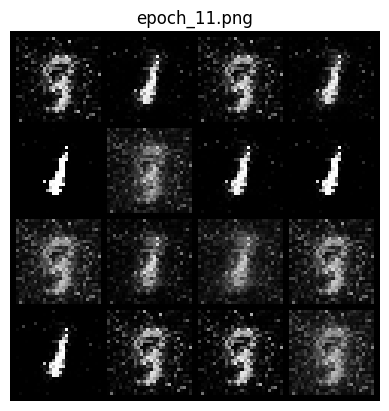

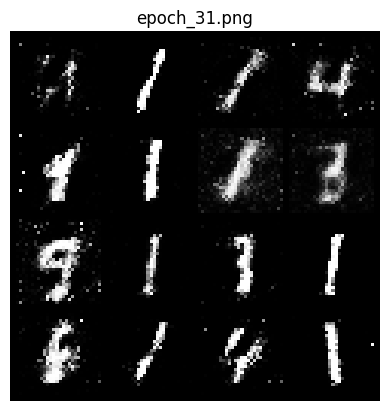

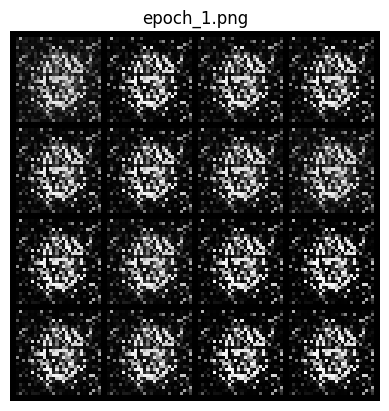

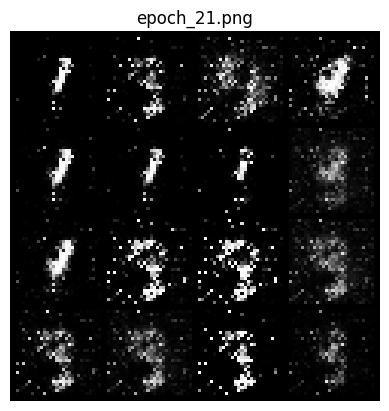

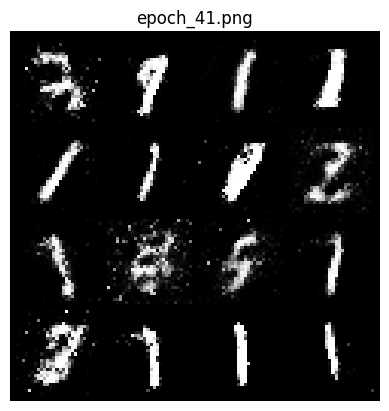

In [38]:
for i, name in enumerate(l):
  img_path = os.path.join("/content/gan_images/", name)
  img = plt.imread(img_path)
  plt.imshow(img)
  plt.title(name)
  plt.axis("off")
  plt.show()